# Rumination classification - averaged participants' epochs

### Imports

In [1]:
%load_ext lab_black
import os
import pickle
from time import time
import pywt
import mne
import scipy
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import cesium.featurize
from plotly.subplots import make_subplots
from ipywidgets import Dropdown, FloatRangeSlider, IntSlider, FloatSlider, interact
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import sys

sys.path.append("..")
from utils import *

---------------------------

### Loading data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [2]:
tmin, tmax = -0.1, 0.6
signal_frequency = 256
ERROR = 0
CORRECT = 1
random_state = 0

In [3]:
channels_order_list = [
    "Fp1",
    "AF7",
    "AF3",
    "F1",
    "F3",
    "F5",
    "F7",
    "FT7",
    "FC5",
    "FC3",
    "FC1",
    "C1",
    "C3",
    "C5",
    "T7",
    "TP7",
    "CP5",
    "CP3",
    "CP1",
    "P1",
    "P3",
    "P5",
    "P7",
    "P9",
    "PO7",
    "PO3",
    "O1",
    "Iz",
    "Oz",
    "POz",
    "Pz",
    "CPz",
    "Fpz",
    "Fp2",
    "AF8",
    "AF4",
    "AFz",
    "Fz",
    "F2",
    "F4",
    "F6",
    "F8",
    "FT8",
    "FC6",
    "FC4",
    "FC2",
    "FCz",
    "Cz",
    "C2",
    "C4",
    "C6",
    "T8",
    "TP8",
    "CP6",
    "CP4",
    "CP2",
    "P2",
    "P4",
    "P6",
    "P8",
    "P10",
    "PO8",
    "PO4",
    "O2",
]
channels_dict = dict(zip(channels_order_list, np.arange(1, 64, 1)))

Define significant channels - rest will be excluded

In [4]:
red_box = [
    "F1",
    "Fz",
    "F2",
    "FC1",
    "FCz",
    "FC2",
    "C1",
    "Cz",
    "C2",
    "CP1",
    "CPz",
    "CP2",
    "P1",
    "Pz",
    "P2",
]
significant_channels = [channels_dict[channel] for channel in red_box]

#### Read the data

In [5]:
df_name = "go_nogo_df_mean"
pickled_data_filename = "../../data/" + df_name + ".pkl"
info_filename = "../../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"

# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../../data/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [6]:
epochs_df.shape

(18545, 32)

#### Average participants' error and correct epochs

In [7]:
averaged_epochs_df = (
    epochs_df.groupby(
        ["id", "marker"],
        sort=False,
    )
    .apply(
        lambda group_df: pd.Series(
            {
                "epoch": np.mean(group_df["epoch"]),
                "Rumination Full Scale": np.mean(group_df["Rumination Full Scale"]),
            }
        )
    )
    .reset_index()
)

-----------------------

## Training and predictions

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tempfile import mkdtemp
from sklearn.model_selection import RepeatedKFold


from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")


import numpy as np
import scipy.stats

#### Standard features for EEG analysis provided by Guo et al. (2012)

In [9]:
def std_signal(t, m, e):
    return np.std(m)


def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))


def mean_energy_signal(t, m, e):
    return np.mean(m ** 2)


def skew_signal(t, m, e):
    return scipy.stats.skew(m)


def mean_signal(t, m, e):
    return np.mean(m)

In [10]:
guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean_energy": mean_energy_signal,
}

step_in_ms = 50
step_tp = int(signal_frequency * step_in_ms / 1000)

#### Calculate p-value with permutation test

In [11]:
from sklearn.model_selection import permutation_test_score


def calculate_p_permutations(estimator, X, y, cv=3, n_permutations=100, n_jobs=10):

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator, X, y, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs
    )

    # summarize
    print(f"     The permutation P-value is = {pvalue_:.3f}")
    #     print(f"     The permutation score is = {score_:.3f}\n")

    return score_, pvalue_

In [12]:
# from mlxtend.evaluate import paired_ttest_5x2cv
# from sklearn.dummy import DummyClassifier


# def calculate_p(estimator, X, y):
#     baseline_estimator = DummyClassifier(strategy="most_frequent")

#     # check if difference between algorithms is real
#     t, p = paired_ttest_5x2cv(
#         estimator1=baseline_estimator,
#         estimator2=estimator,
#         X=X,
#         y=y,
#         scoring="accuracy",
#         random_seed=0,
#     )

#     # summarize
#     print(f"     The P-value is = {p:.3f}")
#     print(f"     The t-statistics is = {t:.3f}\n")

#     return t, p

#### Validation curves - for parameters' insight

In [13]:
import matplotlib.pyplot as plt


def pooled_var(stds):
    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    n = 5  # size of each group
    return np.sqrt(sum((n - 1) * (stds ** 2)) / len(stds) * (n - 1))


def show_validation_curves(cv_results, grid_params):

    df = pd.DataFrame(cv_results)
    results = [
        "mean_test_balanced_accuracy",
        "mean_train_balanced_accuracy",
        "std_test_balanced_accuracy",
        "std_train_balanced_accuracy",
    ]

    fig, axes = plt.subplots(
        1, len(grid_params), figsize=(5 * len(grid_params), 7), sharey="row"
    )
    axes[0].set_ylabel("Score", fontsize=25)

    for idx, (param_name, param_range) in enumerate(grid_params.items()):
        grouped_df = df.groupby(f"param_{param_name}")[results].agg(
            {
                "mean_train_balanced_accuracy": "mean",
                "mean_test_balanced_accuracy": "mean",
                "std_train_balanced_accuracy": pooled_var,
                "std_test_balanced_accuracy": pooled_var,
            }
        )

        previous_group = df.groupby(f"param_{param_name}")[results]
        axes[idx].set_xlabel(param_name, fontsize=10)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].set_xscale("log")
        lw = 2
        axes[idx].plot(
            param_range,
            grouped_df["mean_train_balanced_accuracy"],
            label="Training score",
            color="darkorange",
            lw=lw,
        )
        axes[idx].fill_between(
            param_range,
            grouped_df["mean_train_balanced_accuracy"]
            - grouped_df["std_train_balanced_accuracy"],
            grouped_df["mean_train_balanced_accuracy"]
            + grouped_df["std_train_balanced_accuracy"],
            alpha=0.2,
            color="darkorange",
            lw=lw,
        )
        axes[idx].plot(
            param_range,
            grouped_df["mean_test_balanced_accuracy"],
            label="Cross-validation score",
            color="navy",
            lw=lw,
        )
        axes[idx].fill_between(
            param_range,
            grouped_df["mean_test_balanced_accuracy"]
            - grouped_df["std_test_balanced_accuracy"],
            grouped_df["mean_test_balanced_accuracy"]
            + grouped_df["std_test_balanced_accuracy"],
            alpha=0.2,
            color="navy",
            lw=lw,
        )

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle("Validation curves", fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)
    plt.show()

----------------------

### Create X and y sets

In [14]:
dataset = ERROR
dataset_name = "correct" if dataset == CORRECT else "error"

In [15]:
X_train = np.array(
    averaged_epochs_df[averaged_epochs_df["marker"] == dataset]["epoch"].to_list()
)
y_train = np.array(
    averaged_epochs_df[averaged_epochs_df["marker"] == dataset][
        "Rumination Full Scale"
    ].to_list()
)

Split data by median into two groups: high/low rumination

In [16]:
rumination_median = np.median(y_train)
HIGH = 1
LOW = 0

In [17]:
for i in range(len(y_train)):
    if y_train[i] < rumination_median:
        y_train[i] = LOW
    else:
        y_train[i] = HIGH

In [18]:
X_test = []
y_test = []

In [19]:
rumination_median

3.625

---------------------

### Define data transformers 

In [20]:
from __future__ import division
from scipy.signal import butter, lfilter
from sklearn.base import TransformerMixin, BaseEstimator


class LowpassFilter(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        fs = signal_frequency
        cutoff = 45  # Hz
        B, A = butter(
            6, cutoff / (fs / 2), btype="low", analog=False
        )  # 6th order Butterworth low-pass

        filtered_epochs_per_channel = []
        for channel in X:
            filtered_epochs = np.array(
                [lfilter(B, A, epoch, axis=0) for epoch in channel]
            )
            filtered_epochs_per_channel.append(filtered_epochs)
        filtered_epochs_per_channel = np.array(filtered_epochs_per_channel)
        return filtered_epochs_per_channel


class IcaPreprocessing(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        timepoints_per_channel = np.concatenate(X, axis=1)
        return timepoints_per_channel.T


class IcaPostprocessing(TransformerMixin, BaseEstimator):
    def __init__(self, timepoints_count):
        super().__init__()
        self.timepoints_count = timepoints_count

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ica_transposed = X.T
        ica_n_components = X.shape[1]

        epochs_count = int(X_ica_transposed.shape[1] / self.timepoints_count)
        data_per_channel = X_ica_transposed.reshape(
            ica_n_components, epochs_count, self.timepoints_count
        )

        return data_per_channel


class Cwt(TransformerMixin, BaseEstimator):
    def __init__(self, mwt="morl", cwt_density=2, cwt_octaves=6):
        # for octaves=6, the highest frequency is 45.25 Hz
        super().__init__()
        self.mwt = mwt
        self.cwt_density = cwt_density
        self.cwt_octaves = cwt_octaves

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cwt_per_channel = []
        for data in X:
            data_cwt = np.array(
                [
                    cwt(epoch, self.mwt, self.cwt_density, self.cwt_octaves)
                    for epoch in data
                ]
            )
            cwt_per_channel.append(data_cwt)
        cwt_per_channel = np.array(cwt_per_channel)
        return cwt_per_channel


class CwtFeatureVectorizer(TransformerMixin, BaseEstimator):
    def __init__(self, feature_dict):
        super().__init__()
        self.feature_dict = feature_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectorized_data = []
        for data_cwt in X:
            # cesium functions
            feature_set_cwt = cesium.featurize.featurize_time_series(
                times=None,
                values=data_cwt,
                errors=None,
                features_to_use=list(self.feature_dict.keys()),
                custom_functions=self.feature_dict,
            )
            features_per_epoch = feature_set_cwt.to_numpy()
            vectorized_data.append(features_per_epoch)
        vectorized_data = np.array(vectorized_data)
        return vectorized_data


# reshape data from (channels x epoch x features) to (epochs x channles x features)
# and then flatten it to (epoch x channels*features)
class PostprocessingTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectorized_data = np.stack(X, axis=1)
        epochs_per_channel_feature = vectorized_data.reshape(
            vectorized_data.shape[0], -1
        )
        return epochs_per_channel_feature


class ChannelExtraction(TransformerMixin, BaseEstimator):
    def __init__(self, channel_list):
        super().__init__()
        self.channel_list = channel_list

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        epochs_per_channels = np.transpose(X, (1, 0, 2))
        epochs_per_selected_channels = []

        for channel in self.channel_list:
            this_data = epochs_per_channels[channel]
            epochs_per_selected_channels.append(this_data)

        epochs_per_selected_channels = np.array(epochs_per_selected_channels)
        selected_channels_per_epoch = np.transpose(
            epochs_per_selected_channels, (1, 0, 2)
        )
        #         print(f"EXTRACTION {selected_channels_per_epoch.shape}")
        return selected_channels_per_epoch


# swap channels and epochs axes: from epoch_channel_timepoints to channel_epoch_timepoints and vice versa
class ChannelDataSwap(TransformerMixin, BaseEstimator):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data_channel_swaped = np.transpose(X, (1, 0, 2))
        return data_channel_swaped


class BinTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, step):
        super().__init__()
        self.step = step

    def bin_epoch(self, epoch):
        new_channels = []
        for channel in epoch:
            bins_channel = []
            index = 0
            while index + self.step < len(channel):
                this_bin = np.mean(channel[index : index + self.step])
                bins_channel.append(this_bin)
                index += self.step
            new_channels.append(bins_channel)
        return new_channels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binned_data = np.array([self.bin_epoch(epoch) for epoch in X])
        return binned_data


# transforms energy of each sub-band into relative energy of sub-band
def RelativeEnergyTransformer():
    def transform(X):
        vectorized_data = []

        for epoch in X:
            total_energy_of_epoch = np.sum(epoch)
            sub_band_relative_energies = np.array(
                [(sub_band_energy / total_energy_of_epoch) for sub_band_energy in epoch]
            )
            vectorized_data.append(sub_band_relative_energies)

        vectorized_data = np.array(vectorized_data)
        return vectorized_data

    return FunctionTransformer(func=transform)

-----------------------
### Define searching experiment

In [21]:
def rate_classifier(
    X_train, y_train, X_test, y_test, classifier, classifier_params, base_steps, cv=5
):
    # define cross-validation method
    cv_skf = StratifiedKFold(n_splits=3)

    pipeline = Pipeline(steps=base_steps + [classifier])
    param_grid = classifier_params
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv_skf,
        scoring={"balanced_accuracy", "precision"},
        refit="balanced_accuracy",
        return_train_score=True,
        n_jobs=10,
        verbose=10,
    )
    grid_search.fit(X_train, y_train)

    return grid_search

In [22]:
def run_experiment(
    tested_classifiers,
    classifier_params,
    pipeline_name,
    X_train,
    X_test,
    y_train,
    y_test,
    dataset_name,
    base_steps,
    results_df,
    function_name="-",
):

    for (classifier, params) in tested_classifiers:
        print(f"Rating {classifier} \n")
        tested_params = {**classifier_params, **params}

        grid_result = rate_classifier(
            X_train,
            y_train,
            X_test,
            y_test,
            classifier,
            tested_params,
            base_steps,
            cv=2,
        )

        #     predictions = grid_result.predict(X_test)
        #     r2 = grid_result.score(X_test, y_test)
        #     mae = mean_absolute_error(y_test, predictions)
        #     r2_adj = r2_adjusted_scorer(y_test, predictions, len(X_test[0]), len(X_test))

        best_estimator_index = grid_result.best_index_
        mean_cv_balanced_accuracy = grid_result.cv_results_[
            "mean_test_balanced_accuracy"
        ][best_estimator_index]
        std_cv_balanced_accuracy = grid_result.cv_results_[
            "std_test_balanced_accuracy"
        ][best_estimator_index]
        mean_cv_precision = grid_result.cv_results_["mean_test_precision"][
            best_estimator_index
        ]
        std_cv_precision = grid_result.cv_results_["std_test_precision"][
            best_estimator_index
        ]
        mean_train_balanced_accuracy = grid_result.cv_results_[
            "mean_train_balanced_accuracy"
        ][best_estimator_index]

        print(f"     Best parameters: {grid_result.best_params_}")
        print(
            f"     mean acc: {mean_cv_balanced_accuracy}           ± {round(std_cv_balanced_accuracy,3)}"
        )
        print(f"     mean acc train: {mean_train_balanced_accuracy}")

        cv_results = grid_result.cv_results_
        #         t_statistics, p_value = calculate_p(
        #             grid_result.best_estimator_, X_train, y_train
        #         )

        scores_, pvalue_ = calculate_p_permutations(
            grid_result.best_estimator_, X_train, y_train
        )

        #         show_validation_curves(grid_result.cv_results_, tested_params)

        data = {
            "data_set": dataset_name,
            "pipeline_name": pipeline_name,
            "model": classifier[0],
            "parameters": grid_result.best_params_,
            "mean_cv_balanced_accuracy": mean_cv_balanced_accuracy,
            "std_cv_balanced_accuracy": std_cv_balanced_accuracy,
            "mean_cv_precision": mean_cv_precision,
            "std_cv_precision": std_cv_precision,
            "cv_results": cv_results,
            "mean_train_balanced_accuracy": mean_train_balanced_accuracy,
            "p-value": pvalue_,
            "best_estimator": grid_result.best_estimator_,
            #             "t-stats": t_statistics,
        }

        results_df = results_df.append(data, ignore_index=True)
    return results_df

-----------------
### Define architectures

In [23]:
# ERP-bins + ERP-bins-cwt-features


def erp_bins_features_steps(feature_function_dict):

    functions_base_steps = [
        ("cwt", Cwt()),
        (
            "cwt_feature",
            CwtFeatureVectorizer(feature_dict=feature_function_dict),
        ),
        ("postprocessing_func", PostprocessingTransformer()),
    ]
    functions_pipeline = Pipeline(steps=functions_base_steps)

    bins_base_steps = [
        ("data_channel_swap_after_filter", ChannelDataSwap()),
        ("binning", BinTransformer(step=step_tp)),
        ("data_channel_swap", ChannelDataSwap()),
        ("postprocessing_bins", PostprocessingTransformer()),
    ]
    bins_pipeline = Pipeline(steps=bins_base_steps)

    combined_features = FeatureUnion(
        [("bins", bins_pipeline), ("functins", functions_pipeline)]
    )

    steps = [
        (
            "channels_filtering",
            ChannelExtraction(significant_channels),
        ),
        ("data_channel_swap_filter", ChannelDataSwap()),
        ("lowpass_filter", LowpassFilter()),
        ("features", combined_features),
        ("scaler", StandardScaler()),
        ("feature_selection", PCA(random_state=random_state)),
    ]

    return steps

In [24]:
# Erp-bins
def erp_bins_steps():
    steps = [
        (
            "channels_filtering",
            ChannelExtraction(significant_channels),
        ),
        ("data_channel_swap_filter", ChannelDataSwap()),
        ("lowpass_filter", LowpassFilter()),
        ("data_channel_swap_after_filter", ChannelDataSwap()),
        ("binning", BinTransformer(step=step_tp)),
        ("data_channel_swap", ChannelDataSwap()),
        ("postprocessing", PostprocessingTransformer()),
        ("scaler", StandardScaler()),
        ("feature_selection", PCA(random_state=random_state)),
    ]

    return steps

In [25]:
# ICA-bins + ICA-bins-cwt-features


def ica_bins_features_steps(feature_function_dict):

    steps = [
        (
            "channels_filtering",
            ChannelExtraction(significant_channels),
        ),
        ("ica_preprocessing", IcaPreprocessing()),
        #         ("ica", FastICA(random_state=random_state)),
        ("spatial_filter", PCA(random_state=random_state)),
        (
            "ica_postprocessing",
            IcaPostprocessing(timepoints_count=X_train.shape[-1]),
        ),
        ("lowpass_filter", LowpassFilter()),
        (
            "features",
            FeatureUnion(
                [
                    (
                        "bins",
                        Pipeline(
                            [
                                ("channel_data_swap", ChannelDataSwap()),
                                ("binning", BinTransformer(step=step_tp)),
                                ("data_channel_swap", ChannelDataSwap()),
                                ("postprocessing_bins", PostprocessingTransformer()),
                            ]
                        ),
                    ),
                    (
                        "functions",
                        Pipeline(
                            [
                                ("cwt", Cwt()),
                                (
                                    "cwt_feature",
                                    CwtFeatureVectorizer(
                                        feature_dict=feature_function_dict
                                    ),
                                ),
                                (
                                    "postprocessing_functions",
                                    PostprocessingTransformer(),
                                ),
                            ]
                        ),
                    ),
                ]
            ),
        ),
        ("scaler", StandardScaler()),
        ("feature_selection", PCA(random_state=random_state)),
    ]

    return steps

In [26]:
# ICA-bins


def ica_bins_steps():

    steps = [
        (
            "channels_filtering",
            ChannelExtraction(significant_channels),
        ),
        ("ica_preprocessing", IcaPreprocessing()),
        #         ("ica", FastICA(random_state=random_state)),
        ("spatial_filter", PCA(random_state=random_state)),
        (
            "ica_postprocessing",
            IcaPostprocessing(timepoints_count=X_train.shape[-1]),
        ),
        ("lowpass_filter", LowpassFilter()),
        ("channel_data_swap", ChannelDataSwap()),
        ("binning", BinTransformer(step=step_tp)),
        ("data_channel_swap", ChannelDataSwap()),
        ("postprocessing", PostprocessingTransformer()),
        ("scaler", StandardScaler()),
        ("feature_selection", PCA(random_state=random_state)),
    ]

    return steps

# Experiments

In [27]:
classifier_params = dict(
    spatial_filter__n_components=np.arange(1, 15, 2),
    feature_selection__n_components=np.arange(3, 9, 1),
)

### Searching best regularization parameters

In [ ]:
res = pd.DataFrame()

In [ ]:
# Done
# pipeline_name = "ICA_bins_cwt_features"
# pipeline_name='PCA_15_bins_functions'
# this_steps = ica_bins_features_steps(guo_features)

In [ ]:
# # Done
# pipeline_name = "ERP_bins_cwt_features"
# this_steps = erp_bins_features_steps(guo_features)

In [ ]:
# Done
pipeline_name = "PCA_15_bins"
# pipeline_name = "PCA_4_bins"
this_steps = ica_bins_steps()

In [ ]:
# # Done
# pipeline_name = "ERP_bins"
# this_steps = erp_bins_steps()

In [ ]:
# the best the best - c=10, gamma=0.001 - ICA_bins
for C in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    #     for epsilon in [0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:

        svc = ("svc", SVC())
        svc_params = dict(
            svc__kernel=["rbf"],
            svc__C=[C],
            svc__gamma=[gamma],
            #             svc__epsilon=[epsilon],
        )

        tested_classifiers = [
            (svc, svc_params),
        ]

        # rate different models
        res = run_experiment(
            tested_classifiers,
            classifier_params,
            pipeline_name,
            X_train,
            X_test,
            y_train,
            y_test,
            dataset_name,
            this_steps,
            res,
        )

In [ ]:
for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    #     for epsilon in [0.0001, 0.001, 0.01, 0.1, 1]:
    #         for gamma in [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:

    svc = ("svc", SVC())
    svc_params = dict(
        svc__kernel=["linear"],
        svc__C=[C],
        svc__gamma=["scale"],
        #             svc__epsilon=[epsilon],
    )

    tested_classifiers = [
        (svc, svc_params),
    ]

    # rate different models
    res = run_experiment(
        tested_classifiers,
        classifier_params,
        pipeline_name,
        X_train,
        X_test,
        y_train,
        y_test,
        dataset_name,
        this_steps,
        res,
    )

In [ ]:
# C=0.01 l1=0.01 , 0.1,0.001,0.1,0.5

for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    for l1_ratio in [
        0.0000001,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.1,
        0.3,
        0.5,
        0.7,
        1,
    ]:

        lr = ("lr", LogisticRegression())
        lr_params = dict(
            lr__penalty=["elasticnet"],
            lr__solver=["saga"],
            lr__l1_ratio=[l1_ratio],
            lr__C=[C],
            lr__random_state=[random_state],
        )

        tested_classifiers = [(lr, lr_params)]

        # rate different models
        res = run_experiment(
            tested_classifiers,
            classifier_params,
            pipeline_name,
            X_train,
            X_test,
            y_train,
            y_test,
            dataset_name,
            this_steps,
            res,
        )

In [ ]:
# for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:

#     lr = ("lr", LogisticRegression())
#     lr_params = dict(lr__C=[C])

#     tested_classifiers = [(lr, lr_params)]

#     # rate different models
#     results_df = run_experiment(
#         tested_classifiers,
#         classifier_params,
#         pipeline_name,
#         X_train,
#         X_test,
#         y_train,
#         y_test,
#         dataset_name,
#         this_steps,
#         results_df,
#     )

#### Run Grid Search 

In [ ]:
results_df = pd.DataFrame()

In [ ]:
svc_rbf = ("svc_rbf", SVC())
svc_rbf_params = dict(
    svc_rbf__kernel=["rbf"],
    svc_rbf__C=[1],
    svc_rbf__gamma=[0.0000001],
)

svc_lin = ("svc_lin", SVC())
svc_lin_params = dict(
    svc_lin__kernel=["linear"],
    svc_lin__C=[0.01],
    svc_lin__gamma=["scale"],
)


lr_en = ("lr_en", LogisticRegression())
lr_en_params = dict(
    lr_en__penalty=["elasticnet"],
    lr_en__solver=["saga"],
    lr_en__C=[0.01],
    lr_en__l1_ratio=[0.000001],
    lr_en__random_state=[random_state],
)


lr = ("lr", LogisticRegression())
lr_params = dict(lr__C=[0.01])


tested_classifiers = [
    (svc_rbf, svc_rbf_params),
    (svc_lin, svc_lin_params),
    (lr_en, lr_en_params),
    #     (lr, lr_params),
]

In [ ]:
# rate different models
results_df = run_experiment(
    tested_classifiers,
    classifier_params,
    pipeline_name,
    X_train,
    X_test,
    y_train,
    y_test,
    dataset_name,
    this_steps,
    results_df,
)

In [ ]:
# with pd.option_context("display.max_rows", 2000):
#     display(results_df)

#### Save the data

In [ ]:
results_df.to_pickle("../../data/classification_PCA_" + dataset_name + ".pkl")

In [ ]:
results_viz = results_df.drop(columns=["best_estimator"])
results_viz.to_pickle(
    "../../data/classification_PCA_vizualization_" + dataset_name + ".pkl"
)

-------------------

### Read data

In [71]:
file_name_ICA = "../../data/results_classification/classification_ICA_error.pkl"
results_ICA = pd.read_pickle(file_name_ICA)

file_name_PCA = "../../data/results_classification/classification_PCA_error.pkl"
results_PCA = pd.read_pickle(file_name_PCA)

file_name_ERP = "../../data/results_classification/classification_ERP_error.pkl"
results_ERP = pd.read_pickle(file_name_ERP)

In [72]:
results_df = pd.concat([results_ICA, results_PCA, results_ERP], ignore_index=True)

In [73]:
results_without_func_df = results_df[
    results_df["pipeline_name"].isin(
        ["ERP_bins", "PCA_15_bins", "PCA_4_bins", "ICA_15_bins", "ICA_4_bins"]
    )
]

#### Recalculate p-values with permutation test

In [ ]:
permutation_results = []

for index, row in results_without_func_df.iterrows():
    estimator = row.best_estimator
    current_acc = row.mean_cv_balanced_accuracy
    #     print(estimator)
    cv_skf = StratifiedKFold(n_splits=3)

    score_, perm_scores_, pvalue_ = permutation_test_score(
        estimator,
        X_train,
        y_train,
        scoring="balanced_accuracy",
        cv=cv_skf,
        n_permutations=1000,
        n_jobs=11,
    )
    print(f"Score: {score_}   df_score: {current_acc}  p_value: {pvalue_}  ")
    permutation_results.append((score_, perm_scores_, pvalue_))

In [ ]:
permutation_results = np.array(permutation_results)
np.save("permutation_results.npy", permutation_results, allow_pickle=True)
perm_res = np.load("permutation_results.npy", allow_pickle=True)

In [ ]:
b = np.split(perm_res, indices_or_sections=3, axis=1)
scores = b[0]
perm_scores = b[1]
p_val = b[2]

In [ ]:
results_without_func_df_copy = results_without_func_df.copy()

In [ ]:
perm_scores_df = pd.DataFrame(perm_scores)

In [ ]:
p_values_df = pd.DataFrame(p_val)

In [ ]:
results_without_func_df["p-value"] = p_values_df
results_without_func_df["permutation_score"] = perm_scores_df

In [ ]:
results_without_func_df.to_pickle(
    "classification_all_results_without_functions_" + dataset_name + ".pkl"
)
results_without_func_df_viz = results_without_func_df.drop(columns=["best_estimator"])
results_without_func_df_viz.to_pickle(
    "classification_all_results_without_functions_viz" + dataset_name + ".pkl"
)
results_without_func_df_viz.to_csv(
    "classification_all_results_without_functions_viz" + dataset_name + ".csv"
)

----------

#### Visualization of permutation scores

In [28]:
results_without_func_df = pd.read_pickle(
    "classification_all_results_without_functions_" + dataset_name + ".pkl"
)

In [29]:
idx = (
    results_without_func_df.groupby(["pipeline_name"])[
        "mean_cv_balanced_accuracy"
    ].transform(max)
    == results_without_func_df["mean_cv_balanced_accuracy"]
)
best_model_in_pipeline_df = results_without_func_df[idx]

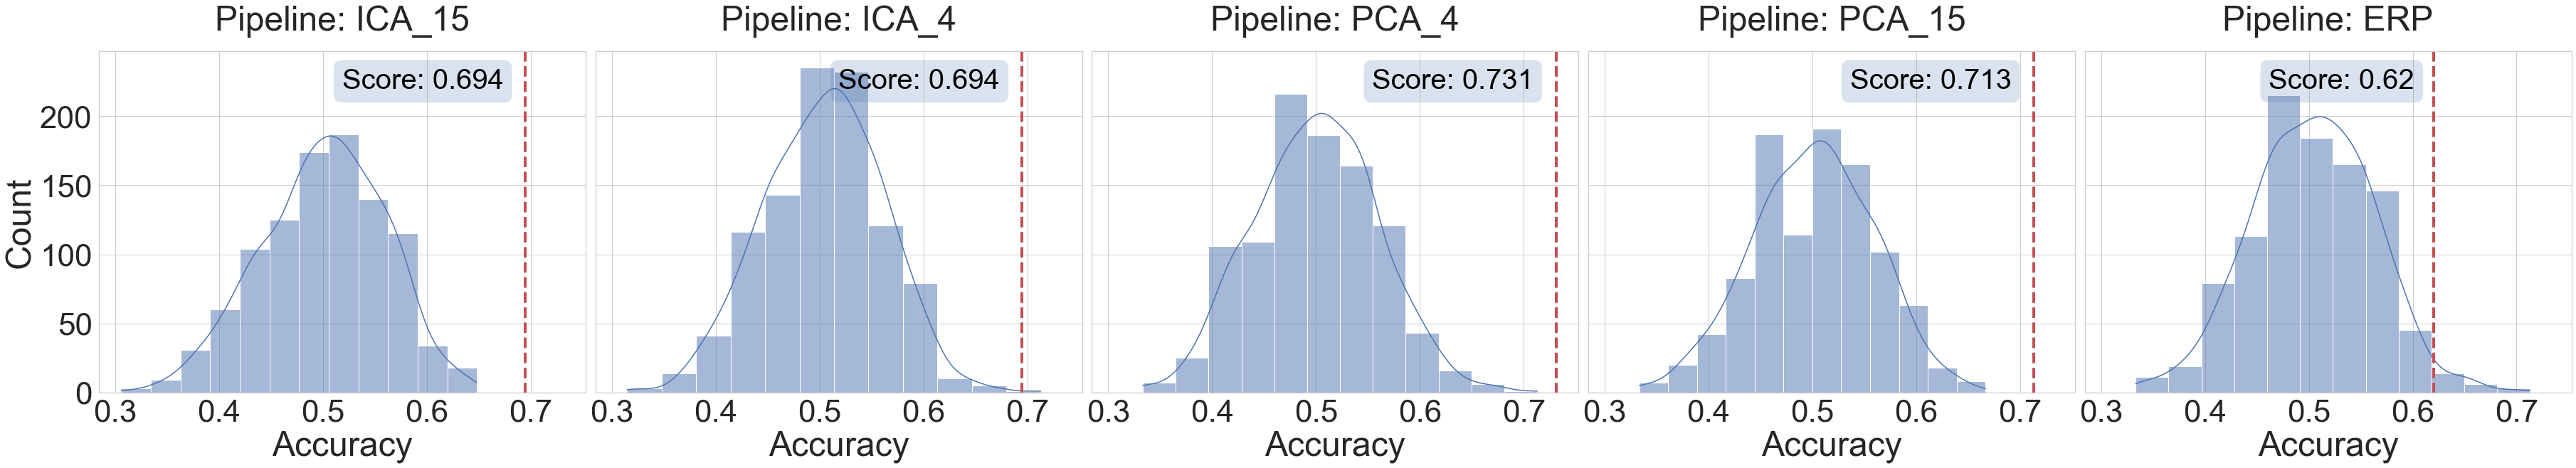

In [105]:
import seaborn as sns

fig, axs = plt.subplots(
    1,
    5,
    figsize=(52, 9),
    facecolor="w",
    edgecolor="k",
    sharey=True,
    sharex=True,
)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, left=0.05)


sns.set(font_scale=4)
sns.set_style("whitegrid")

axs = axs.ravel()
i = 0
for index, row in best_model_in_pipeline_df.iterrows():
    #     plt.figure(figsize=(15, 12))

    sns.histplot(ax=axs[i], x=row.permutation_score, bins=12, kde=True).set(
        xlabel="Accuracy"
    )

    axs[i].axvline(
        row["mean_cv_balanced_accuracy"], -1, color="r", linestyle="--", linewidth=4
    )

    hist = np.histogram(row.permutation_score, bins=12)
    hist_max = max(hist[0])

    text = "Score: " + str(round(row["mean_cv_balanced_accuracy"], 3))
    axs[i].text(
        0.97 * row["mean_cv_balanced_accuracy"],
        220,
        s=text,
        horizontalalignment="right",
        size="small",
        color="black",
        bbox=dict(boxstyle="round", alpha=0.2),
    )
    pipeline_name = row.pipeline_name[:-5]
    axs[i].set_title("Pipeline: " + pipeline_name, pad=30)
    i = i + 1

fig.savefig("classification_permutation_scores.png")

---------------------

### Visualize correlations between predicted and true values

In [74]:
results_without_func_df

,best_estimator,cv_results,data_set,mean_cv_balanced_accuracy,mean_cv_precision,mean_train_balanced_accuracy,model,p-value,parameters,pipeline_name,std_cv_balanced_accuracy,std_cv_precision
3,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.05389809608459473, 0.1052...",error,0.685185,0.704032,0.675926,svc_rbf,0.009901,"{'feature_selection__n_components': 5, 'ica__n...",ICA_15_bins,0.079651,0.081683
4,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.0536950429280599, 0.09826...",error,0.685185,0.729739,0.717593,svc_lin,0.009901,"{'feature_selection__n_components': 8, 'ica__n...",ICA_15_bins,0.013095,0.018189
5,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.05601056416829427, 0.1023...",error,0.694444,0.739975,0.675926,lr_en,0.009901,"{'feature_selection__n_components': 8, 'ica__n...",ICA_15_bins,0.022680,0.042041
9,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.031769116719563804, 0.047...",error,0.694444,0.694737,0.680556,lr_en,0.009901,"{'feature_selection__n_components': 8, 'ica__n...",ICA_4_bins,0.022680,0.041498
10,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.03388826052347819, 0.0436...",error,0.675926,0.733496,0.671296,svc_rbf,0.009901,"{'feature_selection__n_components': 5, 'ica__n...",ICA_4_bins,0.034645,0.040337
11,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.02814650535583496, 0.0460...",error,0.685185,0.698392,0.708333,svc_lin,0.009901,"{'feature_selection__n_components': 8, 'ica__n...",ICA_4_bins,0.057078,0.051916
12,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.041806538899739586, 0.049...",error,0.657407,0.750794,0.671296,svc_rbf,0.009901,"{'feature_selection__n_components': 8, 'spatia...",PCA_4_bins,0.057078,0.059772
13,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.0660249392191569, 0.08633...",error,0.731481,0.745098,0.712963,svc_lin,0.009901,"{'feature_selection__n_components': 7, 'spatia...",PCA_4_bins,0.026189,0.027730
14,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.07982937494913737, 0.0869...",error,0.694444,0.694737,0.685185,lr_en,0.009901,"{'feature_selection__n_components': 7, 'lr_en_...",PCA_4_bins,0.022680,0.041498
15,"(ChannelExtraction(channel_list=[4, 38, 39, 11...","{'mean_fit_time': [0.0909125804901123, 0.10500...",error,0.666667,0.761220,0.634259,svc_rbf,0.009901,"{'feature_selection__n_components': 5, 'spatia...",PCA_15_bins,0.022680,0.040168


In [77]:
estimator_pca = results_without_func_df.best_estimator[13]
estimator_erp = results_without_func_df.best_estimator[19]

In [78]:
predictions_pca = estimator_pca.predict(X_train)
predictions_erp = estimator_erp.predict(X_train)

In [79]:
df_pca = pd.DataFrame(data={"predictions": predictions_pca, "true values": y_train})
df_erp = pd.DataFrame(data={"predictions": predictions_erp, "true values": y_train})

In [87]:
def draw_correlations(x, y, df):
    sns.set(font_scale=1.3)
    sns.set_style("whitegrid")
    sns.lmplot(x=x, y=y, data=df, height=5, aspect=1, ci=95).set_axis_labels(
        "Predicted rumination", "True rumination"
    )

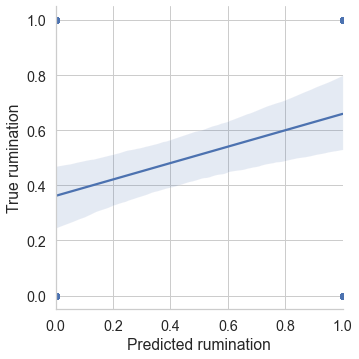

In [88]:
draw_correlations("predictions", "true values", df_erp)

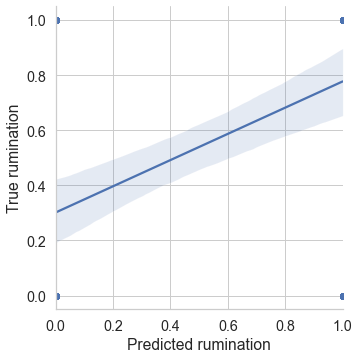

In [82]:
draw_correlations("predictions", "true values", df_pca)

### Vizualization of pipeline features

In [44]:
# shape of one feature vector: 15 (channels) x 15 (bins) = 225 elements

estimator_pca_coeffs = estimator["feature_selection"].components_
estimator_estimator_coeffs = estimator["svc_lin"].coef_[0]

In [45]:
multiplied_components = []
for index in range(0, len(estimator_estimator_coeffs)):
    mul_component = (
        estimator_pca_coeffs[index]
        * estimator_estimator_coeffs[index]
        #         * mean_X_featurs
    )
    multiplied_components.append(mul_component)

In [46]:
multiplied_components = np.array(multiplied_components)
multiplied_components.shape

(7, 30)

In [47]:
multiplied_components = multiplied_components.reshape(
    multiplied_components.shape[0], 2, -1
)

In [48]:
multiplied_components.shape

(7, 2, 15)

In [49]:
data = np.negative(np.sum(multiplied_components, axis=0))
# data = np.sum(multiplied_components, axis=0)

In [50]:
data[0].shape

(15,)

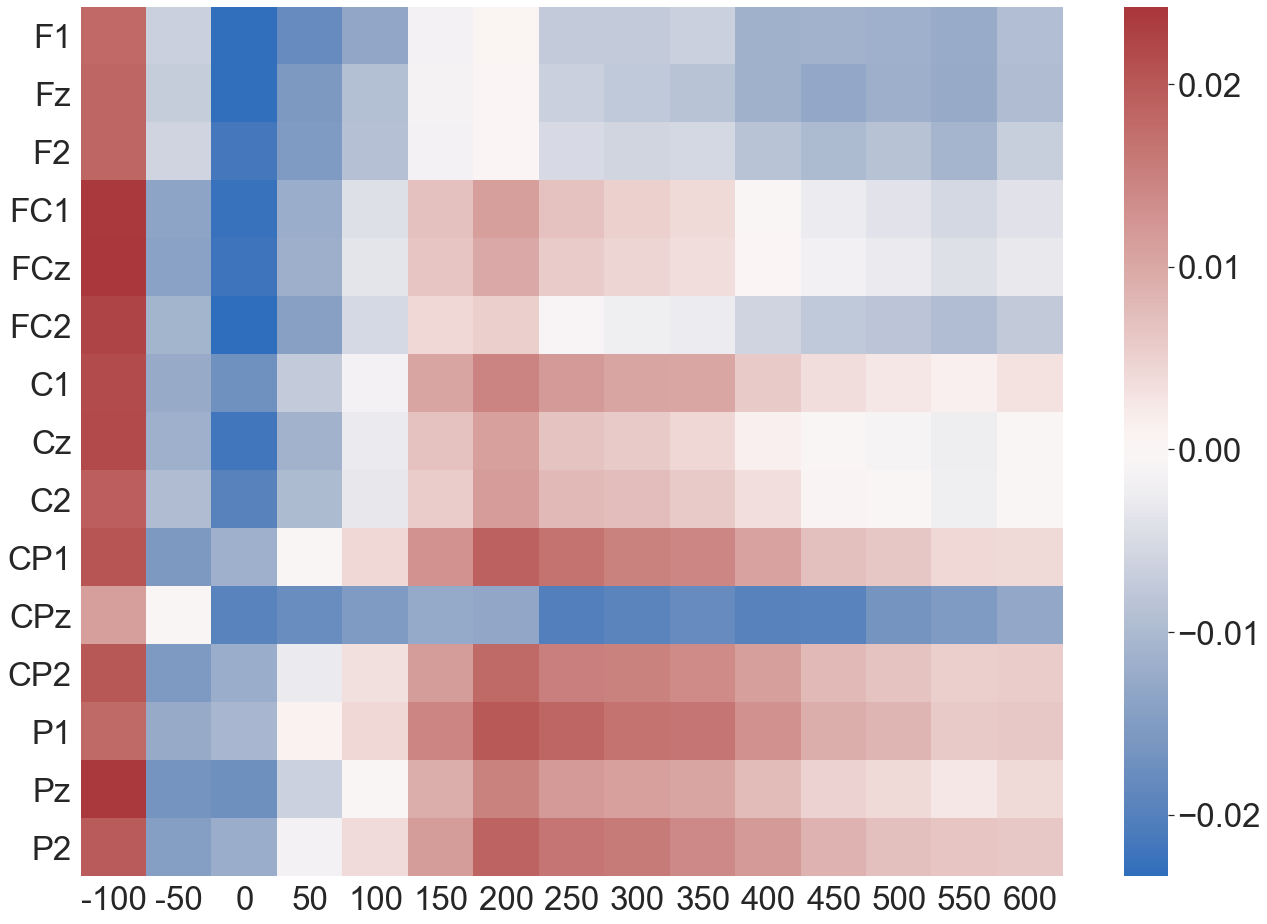

In [40]:
import seaborn as sns

sns.set(font_scale=3)
plt.figure(figsize=(22, 16))

ax = sns.heatmap(
    data=data,
    center=0,
    cmap="vlag",
    yticklabels=red_box,
    xticklabels=[
        -100,
        -50,
        0,
        50,
        100,
        150,
        200,
        250,
        300,
        350,
        400,
        450,
        500,
        550,
        600,
    ],
)
fig = ax.get_figure()
# fig.savefig("rumination_classification_features_coeffs_PCA_4_svc_comp_2.png")
fig.savefig("rumination_classification_features_coeffs_ERP_svc_lin.png")

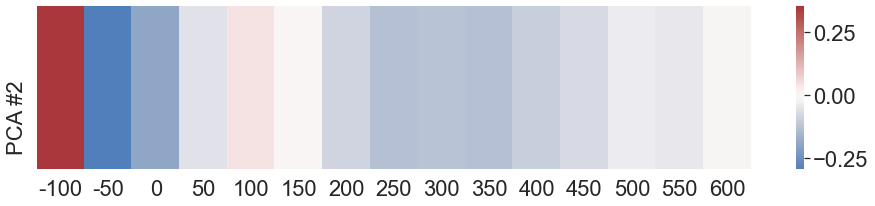

In [55]:
import seaborn as sns

sns.set(font_scale=2)
plt.figure(figsize=(16, 3))

ax = sns.heatmap(
    data=[data[1]],
    center=0,
    cmap="vlag",
    yticklabels=["PCA #2"],
    xticklabels=[
        -100,
        -50,
        0,
        50,
        100,
        150,
        200,
        250,
        300,
        350,
        400,
        450,
        500,
        550,
        600,
    ],
)
fig = ax.get_figure()
fig.savefig("rumination_classification_features_coeffs_PCA_4_svc_PCA_2.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

for i in range(0, len(multiplied_components)):
    #     print(i)
    #     ax = sns.heatmap(multiplied_components[i])
    #     plt.figure() #this creates a new figure on which your plot will appear
    #     seaborn.countplot(use_df);
    plt.figure(i)
    sns.heatmap(multiplied_components[i], cmap="vlag", center=0)
#     display(ax)

In [ ]:
estimator_pca_coeffs.shape

In [56]:
model_without_pca_estimator = estimator.steps[:-3]
features = Pipeline(model_without_pca_estimator).transform(X_train)

In [57]:
features.shape

(108, 30)

In [58]:
X_high = []
X_low = []

for i in range(len(features)):
    if y_train[i] == HIGH:
        #         print(f" IN HIGH: {y_train[i]}")
        X_high.append(features[i])
    else:
        X_low.append(features[i])
#         print(f" IN LOW: {y_train[i]}")
X_high = np.array(X_high)
X_low = np.array(X_low)

In [59]:
mean_X_low = np.mean(X_low, axis=0)
mean_X_low = mean_X_low.reshape(2, -1)

mean_X_high = np.mean(X_high, axis=0)
mean_X_high = mean_X_high.reshape(2, -1)

mean_features = np.mean(features, axis=0)
mean_features = mean_features.reshape(2, -1)

In [60]:
mean_X_low.shape

(2, 15)

In [61]:
data = []
components = ["PCA 1", "PCA 2"]
bucket_width_ms = 1 / 256 * 12 * 1000
xs = np.array([(bucket_width_ms * x - 100) for x in range(len(mean_X_low[0]))])
for index in range(len(mean_X_low)):
    for subindex in range(len(mean_X_low[index])):
        data.append(
            {
                "x": xs[subindex],
                "y": np.negative(mean_X_low[index][subindex]),
                "Rumination": "low",
                "component": components[index],
            }
        )
        data.append(
            {
                "x": xs[subindex],
                "y": np.negative(mean_X_high[index][subindex]),
                "Rumination": "high",
                "component": components[index],
            }
        )
df = pd.DataFrame(data)
df

,x,y,Rumination,component
0,-100.000,-1.739938e-05,low,PCA 1
1,-100.000,-1.595035e-05,high,PCA 1
2,-53.125,-1.691687e-05,low,PCA 1
3,-53.125,-1.774475e-05,high,PCA 1
4,-6.250,-1.693191e-05,low,PCA 1
5,-6.250,-2.027843e-05,high,PCA 1
6,40.625,-2.263107e-05,low,PCA 1
7,40.625,-2.942797e-05,high,PCA 1
8,87.500,-1.753928e-05,low,PCA 1
9,87.500,-1.793273e-05,high,PCA 1


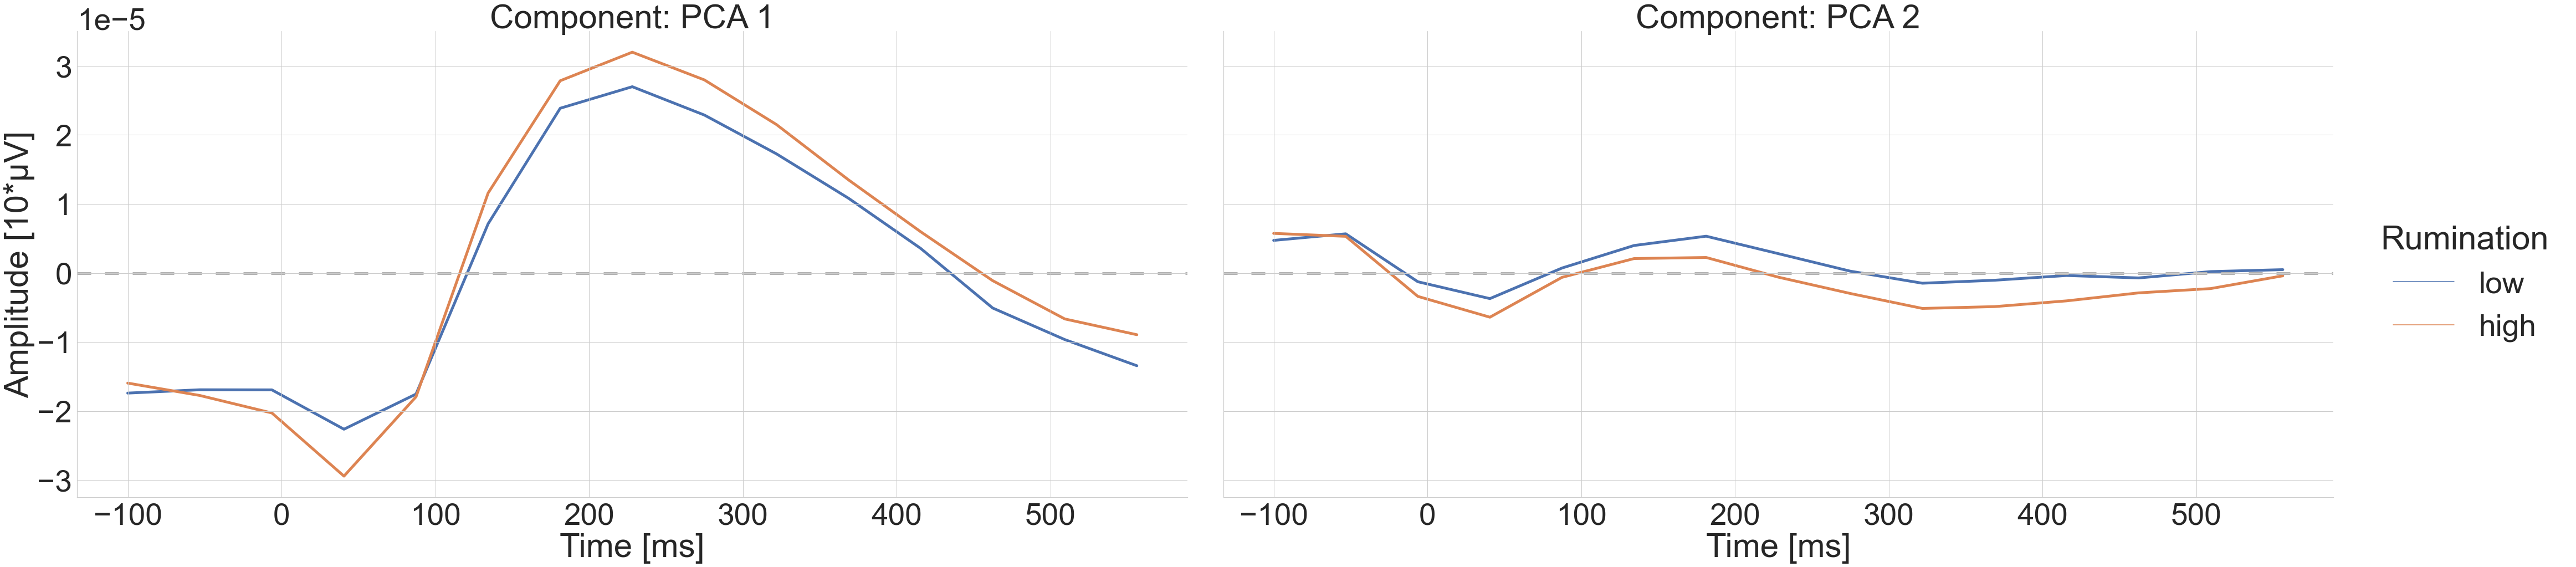

In [70]:
sns.set(font_scale=5)
sns.set_style("whitegrid")

g = sns.relplot(
    x="x",
    y="y",
    hue="Rumination",
    col="component",
    kind="line",
    data=df,
    linewidth=5,
    col_wrap=2,
    zorder=0,
    height=15,
    aspect=2,
)

g.map(
    plt.axhline, y=0, color=".7", dashes=(5, 5), zorder=0, linewidth=5
).set_axis_labels("Time [ms]", "Amplitude [10*µV]").set_titles("Component: {col_name}")

g.savefig("rumination_classification_components_signal_PCA_4_svc.png")